# First Assignment

In [1]:
import nltk
!rm -rf /usr/share/nltk_data/corpora/wordnet
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [2]:
# Import basic libraries
import pandas as pd
import numpy as np
import re
import string
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
# Random Seed at file level for reproducibility
random_seed = 137

np.random.seed(random_seed)
random.seed(random_seed)

In [ ]:
# Import the data
df_train = pd.read_csv('YOUR PATH TO: train_dataset.csv')    # returns a dataframe
df_val = pd.read_csv('YOUR PATH TO: val_dataset.csv')
df_test = pd.read_csv('YOUR PATH TO: test_dataset.csv')

In [5]:
# We run the model without any data preprocessing done
# No need to split the data, since it's already split, but we do need to retrieve the columns
X_train, y_train = df_train["Text"], df_train["Label"]    # corresponds tuples
X_val, y_val = df_val["Text"], df_val["Label"]
X_test, X_test_id = df_test["Text"], df_test["ID"]

In [6]:
# We generate the word cloud, before and once our data is cleaned, so that we can compare if bigger words now have more substance.
# All data should be one single string, for wordcloud.generate to work

def my_wordcloud(set, filename):
    text = ""     # empty string
    iteration = 0
    for sentence in set:
        if(iteration > 0):
            text = text + " "
        text = text + sentence
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  
    plt.show()
    filename_edited = filename + ".png"
    wordcloud.to_file(filename_edited)

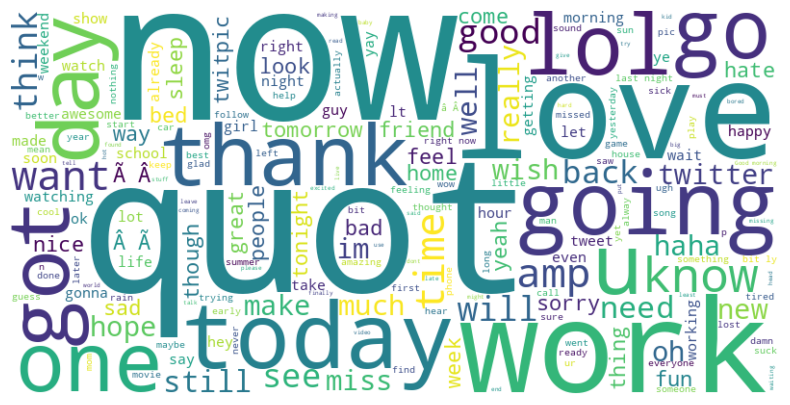

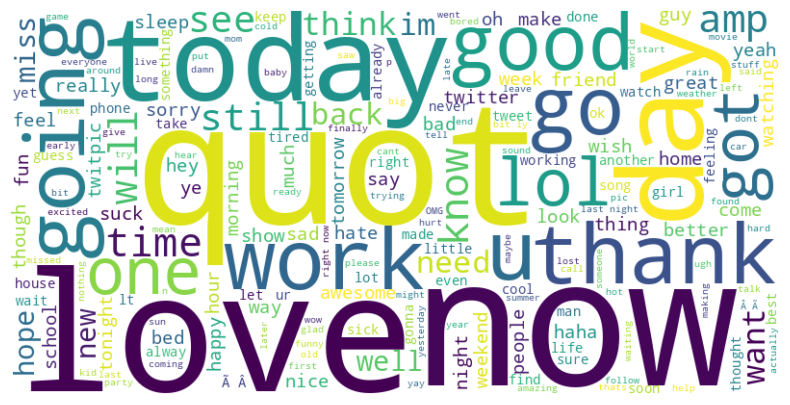

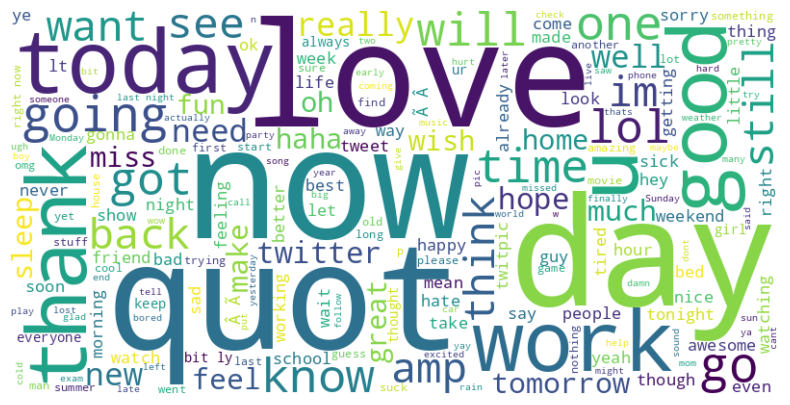

In [7]:
# Create wordcloud before preprocessing
my_wordcloud(X_train, "X_train-before-preprocessing")     
my_wordcloud(X_val, "X_val-before-preprocessing")     
my_wordcloud(X_test, "X_test-before-preprocessing")     

In [8]:
# Preprocessing (all the functions we'll need):
# We tokenize, so that we can preprocess
def my_split(str_arg):
    return str_arg.split(' ')

# lowercase
def my_lower(list_arg):
    length = len(list_arg)
    for i in range(length):
        list_arg[i] = list_arg[i].lower()
    return list_arg

# stop word removal
def my_stopword(list_arg):
    clean_list = []
    for word in list_arg:
        if word not in stopwords.words('english'):
            clean_list.append(word)
    return clean_list

# Lemmatization.
def my_lemmatize(list_arg):
    lemmatizer = WordNetLemmatizer()
    length = len(list_arg)
    for i in range(length):
        list_arg[i] = lemmatizer.lemmatize(list_arg[i])
    return list_arg

# Remove special characters and punctuation
def my_unpunct(list_arg):
    length = len(list_arg)
    for i in range(length):
        list_arg[i] = ''.join([ch for ch in list_arg[i] if ch not in string.punctuation])
    return list_arg

def my_join(list_arg):
    return " ".join(list_arg)    # this is a string function

def my_preprocess(X_set):
    # See report on why certain functions are commented!
    X_set = X_set.apply(my_split)       # we tokenize, so that we can preprocess
    X_set = X_set.apply(my_lower)       # we lowercase
    # X_set = X_set.apply(my_stopword)    # we remove stop words
    # X_set = X_set.apply(my_lemmatize)   # we lemmatize
    # X_set = X_set.apply(my_unpunct)     # we remove special characters and punctuation 
    X_set = X_set.apply(my_join)        # we join all the tokens of one sentence together
    return X_set

In [9]:
# We preprocess train, validation and test set
X_train = my_preprocess(X_train)
X_val = my_preprocess(X_val)
X_test = my_preprocess(X_test)

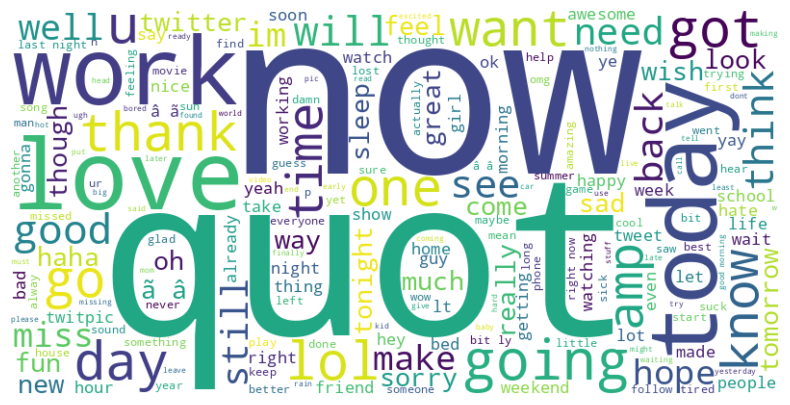

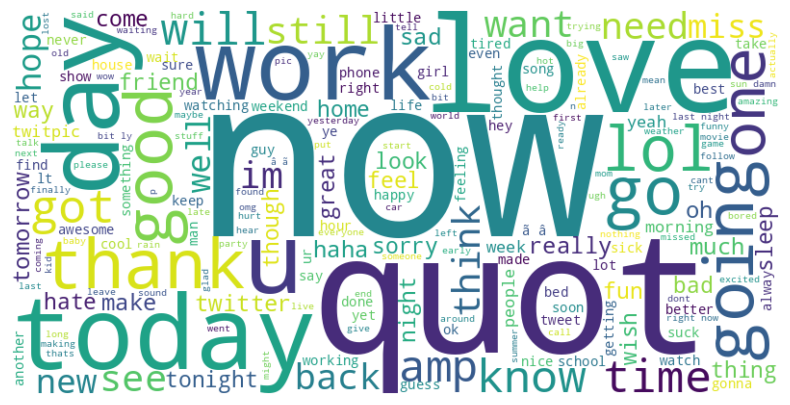

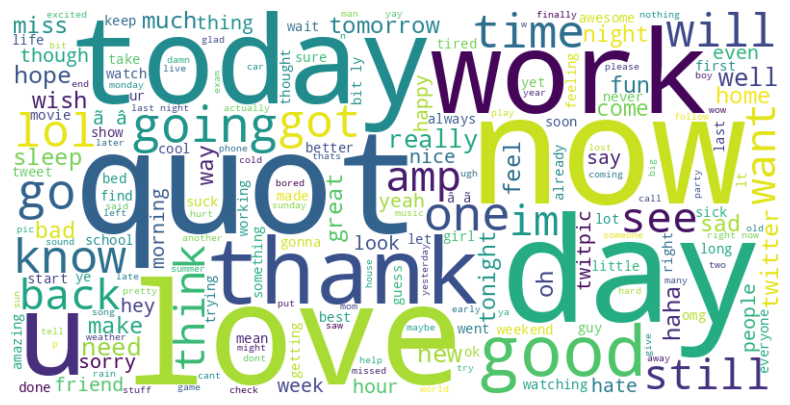

In [10]:
# Create wordcloud after preprocessing
my_wordcloud(X_train, "X_train-after-preprocessing")
my_wordcloud(X_val, "X_val-after-preprocessing")
my_wordcloud(X_test, "X_test-after-preprocessing")

In [11]:
#Από piazza post, δεν ενώνουμε το training και validation set. We perform cv only in training set (https://piazza.com/class/m72z18rxe6f4f7/post/30_f2)
pipe = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False)), ('logisticregression', LogisticRegression())])
param_grid = { 'vectorizer__max_features' : [None, 1000, 50000], 'vectorizer__min_df' : np.linspace(0.000005, 0.00002, 2), 'vectorizer__ngram_range' : [(1,2), (1,3)], 'logisticregression__max_iter' : [100, 300], 'logisticregression__solver' : ['saga', 'lbfgs'], 'logisticregression__C' : [1, 10] }  
grid = GridSearchCV(pipe, param_grid=param_grid, verbose=3)  # verbose = 3 means the computation time for each fold and parameter candidate is displayed, as well as the score is displayed
grid.fit(X_train, y_train)    # Run fit with all sets of parameters.

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=saga, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.794 total time=  11.7s
[CV 2/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=saga, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.798 total time=  11.5s
[CV 3/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=saga, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.796 total time=  11.3s
[CV 4/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=saga, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.790 total time=  10.9s
[CV 5/5] END logisticregression__C

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.795 total time=  20.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.798 total time=  19.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.796 total time=  19.7s
[CV 4/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.790 total time=  17.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.791 total time=  19.7s
[CV 1/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.788 total time=  36.2s
[CV 2/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.792 total time=  29.9s
[CV 3/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.790 total time=  27.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.784 total time=  42.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.785 total time=  43.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.797 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.801 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.799 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.793 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.796 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.797 total time=  12.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.801 total time=  11.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.798 total time=  12.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.793 total time=  12.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.796 total time=  12.1s
[CV 1/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.754 total time=   7.7s
[CV 2/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.759 total time=   7.9s
[CV 3/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.756 total time=   7.8s
[CV 4/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.798 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.800 total time=   9.0s
[CV 3/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.798 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.794 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.795 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.799 total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.799 total time=  15.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.798 total time=  15.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.793 total time=  15.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.796 total time=  15.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.798 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.800 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.799 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.794 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.795 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.798 total time=  15.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.798 total time=  15.5s
[CV 3/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.798 total time=  15.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.793 total time=  15.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=1, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.795 total time=  15.8s
[CV 1/5] END logisticregression__C=1, logisticregression__max_iter=300, logisticregression__solver=saga, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.794 total time=  10.8s
[CV 2/5] END logisticregression__C=1, logisticregression__max_iter=300, logisticregression__solver=saga, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.798 total time=  10.4s
[CV 3/5] END logisticregression__C=1, logisticregression__max_iter=300, logisticregression__solver=saga, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.796 total time=  11.3s
[CV 4/5] END logisticregression__C=1, logisticregression__max_iter=300, logisticregression__so

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.797 total time=  19.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.800 total time=  19.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.799 total time=  19.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.792 total time=  20.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.793 total time=  19.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.800 total time=  43.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.801 total time=  43.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.800 total time=  42.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.793 total time=  42.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.795 total time=  43.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.787 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.789 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.788 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.783 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.785 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.789 total time=  11.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.794 total time=  12.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.792 total time=  12.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.786 total time=  12.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.788 total time=  12.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.754 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.760 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.757 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.754 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.753 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.754 total time=  14.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.759 total time=  14.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.757 total time=  14.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.753 total time=  14.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.753 total time=  14.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.754 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.760 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.757 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.754 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.753 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.754 total time=  14.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.759 total time=  15.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.757 total time=  14.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.753 total time=  14.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.753 total time=  14.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.786 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.787 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.786 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.783 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.784 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.785 total time=  16.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.787 total time=  15.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.786 total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.785 total time=  16.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.781 total time=  15.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.787 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.787 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.786 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.782 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.785 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.787 total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.791 total time=  15.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.788 total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.783 total time=  15.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=100, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.782 total time=  15.8s
[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=saga, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.798 total time=  16.5s
[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=saga, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.799 total time=  16.4s
[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=saga, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.799 total time=  16.6s
[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregressio

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.798 total time=  44.9s
[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.800 total time=  44.3s
[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.799 total time=  43.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.792 total time=  44.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.794 total time=  43.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.800 total time= 1.7min
[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.801 total time= 1.4min
[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.800 total time= 1.2min
[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.793 total time= 1.2min
[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregress

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.786 total time=  13.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.787 total time=  14.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.788 total time=  14.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.783 total time=  14.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.784 total time=  13.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.788 total time=  19.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.791 total time=  19.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.790 total time=  19.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.784 total time=  19.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=None, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.787 total time=  19.7s
[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.754 total time=   9.2s
[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.760 total time=   9.4s
[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=1000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.757 total time=   9.3s
[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregress

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.785 total time=  12.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.786 total time=  13.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.786 total time=  13.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.782 total time=  13.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 2);, score=0.781 total time=  13.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.785 total time=  20.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.786 total time=  19.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.785 total time=  19.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.782 total time=  20.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=5e-06, vectorizer__ngram_range=(1, 3);, score=0.780 total time=  19.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.785 total time=  13.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.787 total time=  13.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.787 total time=  13.5s
[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.781 total time=  12.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 2);, score=0.782 total time=  13.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.785 total time=  19.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.786 total time=  20.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.785 total time=  19.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.782 total time=  19.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END logisticregression__C=10, logisticregression__max_iter=300, logisticregression__solver=lbfgs, vectorizer__max_features=50000, vectorizer__min_df=2e-05, vectorizer__ngram_range=(1, 3);, score=0.781 total time=  20.1s


GridSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(lowercase=False)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [1, 10],
                         'logisticregression__max_iter': [100, 300],
                         'logisticregression__solver': ['saga', 'lbfgs'],
                         'vectorizer__max_features': [None, 1000, 50000],
                         'vectorizer__min_df': array([5.e-06, 2.e-05]),
                         'vectorizer__ngram_range': [(1, 2), (1, 3)]},
             verbose=3)

In [12]:
print(grid.best_params_)
print(grid.best_score_)

{'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'saga', 'vectorizer__max_features': None, 'vectorizer__min_df': 5e-06, 'vectorizer__ngram_range': (1, 3)}
0.7979013960908399


In [13]:
# Data for the learning curve of report
percents = np.linspace(0.1, 1.0, 10)
train_init_size = X_train.size
train_sizes = []
train_results = []
val_results = []

for percent in tqdm(percents):
    X_train_size = round(percent * train_init_size)
    train_sizes.append(X_train_size)
    X_train_temp = X_train.head(X_train_size)
    y_train_temp = y_train.head(X_train_size)
    pipe = Pipeline([('vectorizer', TfidfVectorizer(min_df = 2e-05, ngram_range = (1,3))), ('logisticregression', LogisticRegression(C = 10, max_iter = 100, solver = 'saga'))])
    fit_pipe = pipe.fit(X_train_temp, y_train_temp)
    score_train = fit_pipe.score(X_train_temp, y_train_temp)
    train_results.append(score_train)
    score_val = fit_pipe.score(X_val, y_val)
    val_results.append(score_val)

100%|██████████| 10/10 [02:33<00:00, 15.39s/it]


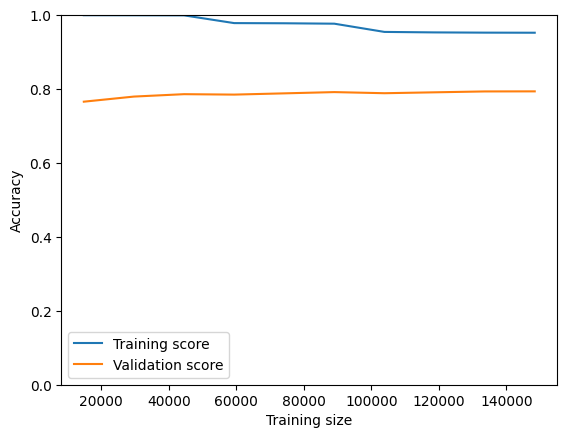

In [14]:
# plotting the points
plt.ylim(0, 1)      # Θέλουμε ο άξονας y που είναι το accuracy να ξεκινά από το μηδέν και να φτάνει μέχρι το ένα

plt.plot(train_sizes, train_results, label="Training score")  
plt.plot(train_sizes, val_results, label="Validation score")  
    
plt.xlabel('Training size')  # naming the x axis  
plt.ylabel('Accuracy')       # naming the y axis  

plt.legend()
plt.savefig('learning-curve.png')

In [15]:
# Extract results to test set and save them to submission.csv
my_vectorizer = TfidfVectorizer(min_df = 5e-06, ngram_range = (1,3))
pipe = Pipeline([('vectorizer', my_vectorizer), ('logisticregression', LogisticRegression(C = 10, max_iter = 100, solver = 'saga'))])
fit_pipe = pipe.fit(X_train, y_train)
y_test = fit_pipe.predict(X_test)
df_test_submission = pd.DataFrame({'ID': X_test_id, 'Label' : y_test})
df_test_submission.to_csv('submission.csv', index=False)

In [16]:
y_val_pred = fit_pipe.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy in val_set: {accuracy: .6f}")

Accuracy in val_set:  0.803849


In [17]:
# accuracy, recall, precision, f1 score
print("Classification Report:\n", classification_report(y_val, y_val_pred)) 

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81     21197
           1       0.82      0.78      0.80     21199

    accuracy                           0.80     42396
   macro avg       0.80      0.80      0.80     42396
weighted avg       0.80      0.80      0.80     42396



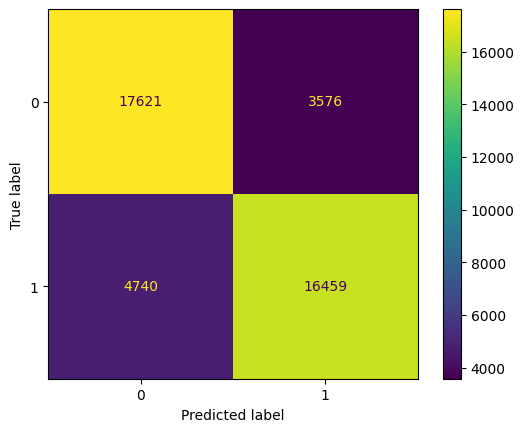

In [18]:
#confusion matrix
from sklearn import metrics 
confusion_matrix = metrics.confusion_matrix(y_val, y_val_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1]) 
cm_display.plot()
plt.savefig('confusion-matrix.png')

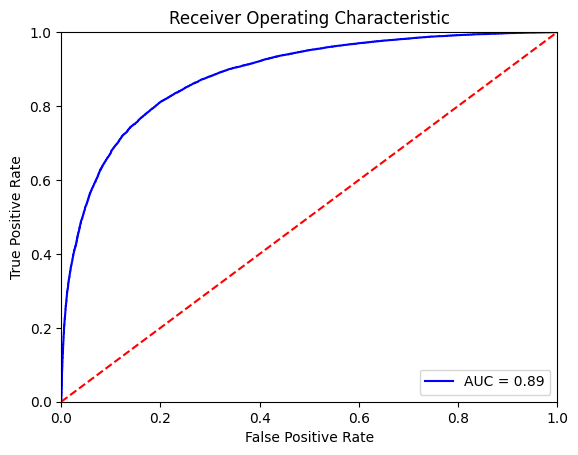

In [19]:
# First way to plot a roc curve
# calculate the fpr and tpr for all thresholds of the classification
y_prob = fit_pipe.predict_proba(X_val)
y_prob = y_prob[:,1]
fpr, tpr, threshold = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc-curve.png')

In [20]:
# print number of vectorizer features (we do this to find possible values for 'max_features' - see report)
# features_names = my_vectorizer.get_feature_names_out()    # We do this when a vectorizer with no parameters
# print(len(features_names))